In [7]:
import os
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, matthews_corrcoef
import seaborn as sns

# Audio
import librosa
import librosa.display

# Scikit learn
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedShuffleSplit

# Keras
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# TensorFlow
from tensorflow.keras.utils import to_categorical

# Ignore warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

dataset = []
for folder in ["Heartbeat_Sounds/set_a/**","Heartbeat_Sounds/set_b/**"]:
    for filename in glob.iglob(folder):
        if os.path.exists(filename):
            label = os.path.basename(filename).split("_")[0]
            duration = librosa.get_duration(filename=filename)
            # skip audio smaller than 3 secs
            if duration>=3:
                slice_size = 3
                iterations = int((duration-slice_size)/(slice_size-1))
                iterations += 1
#                 initial_offset = (duration % slice_size)/2
                initial_offset = (duration - ((iterations*(slice_size-1))+1))/2
                if label not in ["Aunlabelledtest", "Bunlabelledtest"]:
                    for i in range(iterations):
                        offset = initial_offset + i*(slice_size-1)
                        
                        dataset.append({
                                "filename": filename,
                                "label": label,
                                "offset": offset
                            })
                       
                        
dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state=42)
dataset.info()

# Function to extract features
def extract_features(audio_path, offset):
    y, sr = librosa.load(audio_path, offset=offset, duration=3)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)
    return mfccs

# Extract features for all data points
x_data = []
for idx in tqdm(range(len(dataset))):
    x_data.append(extract_features(dataset.filename.iloc[idx], dataset.offset.iloc[idx]))

# Convert to numpy array
x_data = np.asarray(x_data)

# Encode Labels
encoder = LabelEncoder()
encoder.fit(dataset.label)
y_data = encoder.transform(dataset.label)

# Compute class weights
class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_data), y=y_data)

# Convert labels to one-hot encoding
y_data_one_hot = to_categorical(y_data)

# Initialize StratifiedKFold with train_size and test_size
kfold = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

# Initialize lists to store results for each fold
train_accuracies = []
test_accuracies = []
train_auc_scores = []
test_auc_scores = []
train_mcc_scores = []
test_mcc_scores = []
train_conf_matrices = []
test_conf_matrices = []
train_class_reports = []
test_class_reports = []
cm_test_normalized = []
report_test_list = []
cm_test_normalized_list = []

# Loop through the folds
with open('results_heartSound/all_folds_1dcnn5_results.txt', 'w') as common_file:
    for fold, (train_index, test_index) in enumerate(kfold.split(x_data, y_data_one_hot), 1):
        x_train_fold, x_test_fold = x_data[train_index], x_data[test_index]
        y_train_fold, y_test_fold = y_data_one_hot[train_index], y_data_one_hot[test_index]

        # Build the 1DCNN model
        model = Sequential()
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train_fold.shape[1], x_train_fold.shape[2])))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(len(encoder.classes_), activation='softmax'))

        # Compile the model
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        your_epochs = 300  # You can choose an appropriate number of epochs
        your_batch_size = 128  # You can choose an appropriate batch size

        # Train the model
        model.fit(x_train_fold, y_train_fold, epochs=your_epochs, batch_size=your_batch_size, verbose=1)

        # Evaluate on train and test sets
        y_pred_train = model.predict(x_train_fold)
        y_pred_test = model.predict(x_test_fold)
        
        # Generate classification report and confusion matrix for test set
        y_pred_test_labels = np.argmax(y_pred_test, axis=1)
        report_test = classification_report(np.argmax(y_test_fold, axis=1), y_pred_test_labels, output_dict=True)

        # Calculate metrics for train set
        train_accuracy = accuracy_score(np.argmax(y_train_fold, axis=1), np.argmax(y_pred_train, axis=1))
        train_auc = roc_auc_score(y_train_fold, y_pred_train, multi_class='ovr')
        train_mcc = matthews_corrcoef(np.argmax(y_train_fold, axis=1), np.argmax(y_pred_train, axis=1))
        train_cm = confusion_matrix(np.argmax(y_train_fold, axis=1), np.argmax(y_pred_train, axis=1))
        train_class_report = classification_report(np.argmax(y_train_fold, axis=1), np.argmax(y_pred_train, axis=1),
                                                   target_names=encoder.classes_)

        # Calculate metrics for test set
        test_accuracy = accuracy_score(np.argmax(y_test_fold, axis=1), np.argmax(y_pred_test, axis=1))
        test_auc = roc_auc_score(y_test_fold, y_pred_test, multi_class='ovr')
        test_mcc = matthews_corrcoef(np.argmax(y_test_fold, axis=1), np.argmax(y_pred_test, axis=1))
        test_cm = confusion_matrix(np.argmax(y_test_fold, axis=1), np.argmax(y_pred_test, axis=1))
        test_class_report = classification_report(np.argmax(y_test_fold, axis=1), np.argmax(y_pred_test, axis=1),
                                                  target_names=encoder.classes_)

        # Inside the loop where you append accuracies to lists
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        # Calculate std for train and test accuracies
        train_accuracy_std = np.std(train_accuracies)
        test_accuracy_std = np.std(test_accuracies)


        # Save results to the common text file for both train and test sets
        common_file.write(f'Fold {fold} Results:\n')
        common_file.write(f'Train Accuracy: {train_accuracy} (std: {train_accuracy_std})\n')
        common_file.write(f'Train AUC Score: {train_auc}\n')
        common_file.write(f'Train MCC Score: {train_mcc}\n\n')
        common_file.write('Train Confusion Matrix:\n')
        common_file.write(str(train_cm))
        common_file.write('\n\nTrain Classification Report:\n')
        common_file.write(train_class_report)

        common_file.write(f'\n\nTest Accuracy: {test_accuracy} (std: {test_accuracy_std})\n')
        common_file.write(f'Test AUC Score: {test_auc}\n')
        common_file.write(f'Test MCC Score: {test_mcc}\n\n')
        common_file.write('Test Confusion Matrix:\n')
        common_file.write(str(test_cm))
        common_file.write('\n\nTest Classification Report:\n')
        common_file.write(test_class_report)
        
        # Print a separator between folds
        common_file.write("\n" + "="*40 + "\n")
        
        # Calculate average metrics for train set
        avg_train_accuracy = np.mean(train_accuracies)
        avg_train_auc = np.mean(train_auc_scores)
        avg_train_mcc = np.mean(train_mcc_scores)
        avg_train_conf_matrix = np.mean(train_conf_matrices, axis=0)  # Average confusion matrix

        # Convert continuous probabilities to class labels using argmax
        y_pred_train_class = np.argmax(y_pred_train, axis=1)

        # Calculate average metrics for test set
        avg_test_accuracy = np.mean(test_accuracies)
        avg_test_auc = np.mean(test_auc_scores)
        avg_test_mcc = np.mean(test_mcc_scores)
        avg_test_conf_matrix = np.mean(test_conf_matrices, axis=0)  # Average confusion matrix

        # Convert continuous probabilities to class labels using argmax
        y_pred_test_class = np.argmax(y_pred_test, axis=1)
        
        # Calculate average results for train set
        avg_train_class_report = classification_report(np.argmax(y_train_fold, axis=1), y_pred_train_class, target_names=encoder.classes_)

        # Calculate average results for test set
        avg_test_class_report = classification_report(np.argmax(y_test_fold, axis=1), y_pred_test_class, target_names=encoder.classes_)

        # Inside the loop where you plot confusion matrices
        plt.figure()
        train_cm = confusion_matrix(np.argmax(y_train_fold, axis=1), y_pred_train.argmax(axis=1))

        # Round each value in the confusion matrix to 5 decimal places
        rounded_train_cm = np.round(train_cm / np.sum(train_cm, axis=1)[:, np.newaxis], 5)

        sns.heatmap(rounded_train_cm, annot=True, fmt='.5f', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
        plt.title(f'Train Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig(f'1DCNN/train_confusion_matrix_fold_{fold}.png')
        plt.close()

        # Inside the loop where you plot confusion matrices
        plt.figure()
        test_cm = confusion_matrix(np.argmax(y_test_fold, axis=1), y_pred_test.argmax(axis=1))

        # Round each value in the confusion matrix to 5 decimal places
        rounded_test_cm = np.round(test_cm / np.sum(test_cm, axis=1)[:, np.newaxis], 5)

        sns.heatmap(rounded_test_cm, annot=True, fmt='.5f', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
        plt.title(f'Test Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig(f'1DCNN/test_confusion_matrix_fold_{fold}.png')
        plt.close()

        # Inside the loop where you append results to lists
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        train_auc_scores.append(train_auc)
        test_auc_scores.append(test_auc)
        train_mcc_scores.append(train_mcc)
        test_mcc_scores.append(test_mcc)
        train_conf_matrices.append(train_cm)
        test_conf_matrices.append(test_cm)
        train_class_reports.append(train_class_report)
        test_class_reports.append(test_class_report)
        
        # Print a separator between folds
        common_file.write("\n" + "="*40 + "\n")
        
        # Append classification report and confusion matrix to lists
        report_test_list.append(report_test)
        cm_test_normalized_list.append(cm_test_normalized)
        

    # Calculate average metrics for train set
    avg_train_accuracy = np.mean(train_accuracies)
    avg_train_auc = np.mean(train_auc_scores)
    avg_train_mcc = np.mean(train_mcc_scores)

    # Reshape y_train_fold to (num_samples, num_classes)
    y_train_fold_reshaped = to_categorical(y_train_fold, num_classes=len(encoder.classes_))

    # Convert predictions to one-hot encoding
    y_pred_train_one_hot = to_categorical(np.argmax(y_pred_train, axis=1), num_classes=len(encoder.classes_))

    # Calculate average confusion matrix for train set
    avg_train_conf_matrix = np.mean(train_conf_matrices, axis=0).astype(int)


    # Calculate average classification report for train set
    avg_train_class_report = classification_report(
        np.argmax(y_train_fold, axis=1), 
        np.argmax(y_pred_train_one_hot, axis=1), 
        target_names=encoder.classes_, 
        digits=5
    )
    

    # Calculate average metrics for test set
    avg_test_accuracy = np.mean(test_accuracies)
    avg_test_auc = np.mean(test_auc_scores)
    avg_test_mcc = np.mean(test_mcc_scores)

    # Reshape y_test_fold to (num_samples, num_classes)
    y_test_fold_reshaped = to_categorical(y_test_fold, num_classes=len(encoder.classes_))

    # Convert predictions to one-hot encoding
    y_pred_test_one_hot = to_categorical(np.argmax(y_pred_test, axis=1), num_classes=len(encoder.classes_))

    # Calculate average confusion matrix for test set
    avg_test_conf_matrix = np.mean(test_conf_matrices, axis=0).astype(int)

    # Calculate average classification report for test set
    avg_test_class_report = classification_report(
        np.argmax(y_test_fold, axis=1), 
        np.argmax(y_pred_test_one_hot, axis=1), 
        target_names=encoder.classes_, 
        digits=5
    )

    # Inside the loop where you plot the average confusion matrix for the test set
    avg_cm_test_normalized = np.mean(cm_test_normalized_list, axis=0)
    plt.figure()

    avg_test_cm = confusion_matrix(np.argmax(y_test_fold, axis=1), np.argmax(y_pred_test, axis=1))

    # Normalize the confusion matrix by dividing each value by the sum of its row
    normalized_avg_test_cm = avg_test_cm / avg_test_cm.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix for the average test set
    plt.figure()
    sns.heatmap(normalized_avg_test_cm, annot=True, fmt='.5f', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.title(f'Average Test Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('1DCNN/average_test_confusion_matrix.png')
    plt.close()
    
    # Save average results to the common text file
    common_file.write("\n" + "="*40 + "\n")
    common_file.write(f'Average Test Accuracy: {avg_test_accuracy:.5f} (std: {np.std(test_accuracies):.5f})\n')
    common_file.write(f'Average Test AUC Score: {avg_test_auc:.5f}\n')
    common_file.write(f'Average Test MCC Score: {avg_test_mcc:.5f}\n\n')
    common_file.write('Average Test Confusion Matrix:\n')
    common_file.write(str(avg_cm_test_normalized.round(5).astype(int)))  # Display confusion matrix with 5 decimal places
    common_file.write("\n\nAverage Test Classification Report:\n")
    common_file.write(str(avg_test_class_report))


    # Print and write the average results to the common text file
    common_file.write("\n" + "="*40 + "\n")
    common_file.write(f'Average Test Accuracy: {avg_test_accuracy:.5f} (std: {np.std(test_accuracies):.5f})\n')
    common_file.write(f'Average Test AUC Score: {avg_test_auc:.5f}\n')
    common_file.write(f'Average Test MCC Score: {avg_test_mcc:.5f}\n\n')
    common_file.write('Average Test Confusion Matrix:\n')
    common_file.write(str(avg_cm_test_normalized.round(5).astype(int)))  # Display confusion matrix with 5 decimal places
    common_file.write("\n\nAverage Test Classification Report:\n")
    common_file.write(str(avg_test_class_report))


    # Print and write the average results to the common text file
    common_file.write("\n" + "="*40 + "\n")
    common_file.write(f'Average Train Accuracy: {avg_train_accuracy} (std: {np.std(train_accuracies)})\n')
    common_file.write(f'Average Train AUC Score: {avg_train_auc}\n')
    common_file.write(f'Average Train MCC Score: {avg_train_mcc}\n\n')
    common_file.write('Average Train Confusion Matrix:\n')
    common_file.write(str(avg_train_conf_matrix.astype(int)))
    common_file.write("\n\nAverage Train Classification Report:\n")
    common_file.write(str(avg_train_class_report))

    common_file.write("\n" + "="*40 + "\n")
    common_file.write(f'Average Test Accuracy: {avg_test_accuracy} (std: {np.std(test_accuracies)})\n')
    common_file.write(f'Average Test AUC Score: {avg_test_auc}\n')
    common_file.write(f'Average Test MCC Score: {avg_test_mcc}\n\n')
    common_file.write('Average Test Confusion Matrix:\n')
    common_file.write(str(avg_test_conf_matrix.astype(int)))
    common_file.write("\n\nAverage Test Classification Report:\n")
    common_file.write(str(avg_test_class_report))
        
    # Print average results for train set
    print(f'Average Train Accuracy: {avg_train_accuracy}')
    print(f'Average Train AUC Score: {avg_train_auc}')
    print(f'Average Train MCC Score: {avg_train_mcc} \n')
    print("\nAverage Train Classification Report:")
    print(avg_train_class_report)

    # Print average results for test set
    print(f'Average Test Accuracy: {avg_test_accuracy}')
    print(f'Average Test AUC Score: {avg_test_auc}')
    print(f'Average Test MCC Score: {avg_test_mcc} \n')
    print("\nAverage Test Classification Report:")
    print(avg_test_class_report)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1441 entries, 168 to 1126
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  1441 non-null   object 
 1   label     1441 non-null   object 
 2   offset    1441 non-null   float64
dtypes: float64(1), object(2)
memory usage: 45.0+ KB


100%|███████████████████████████████████████████████████████████████████████████████| 1441/1441 [03:19<00:00,  7.24it/s]


Epoch 1/300
9/9 [==============================] - 8s 275ms/step - loss: 12.9118 - accuracy: 0.4210
Epoch 2/300
9/9 [==============================] - 2s 170ms/step - loss: 1.5984 - accuracy: 0.5182
Epoch 3/300
9/9 [==============================] - 1s 144ms/step - loss: 1.0593 - accuracy: 0.5790
Epoch 4/300
9/9 [==============================] - 1s 125ms/step - loss: 0.9624 - accuracy: 0.6285
Epoch 5/300
9/9 [==============================] - 1s 122ms/step - loss: 0.9299 - accuracy: 0.6372
Epoch 6/300
9/9 [==============================] - 1s 124ms/step - loss: 0.8931 - accuracy: 0.6545
Epoch 7/300
9/9 [==============================] - 1s 124ms/step - loss: 0.8564 - accuracy: 0.6589
Epoch 8/300
9/9 [==============================] - 1s 120ms/step - loss: 0.8362 - accuracy: 0.6745
Epoch 9/300
9/9 [==============================] - 2s 197ms/step - loss: 0.8048 - accuracy: 0.6797
Epoch 10/300
9/9 [==============================] - 2s 194ms/step - loss: 0.7976 - accuracy: 0.6997
Epoch 11

9/9 [==============================] - 1s 160ms/step - loss: 0.0365 - accuracy: 0.9861
Epoch 84/300
9/9 [==============================] - 1s 151ms/step - loss: 0.0390 - accuracy: 0.9896
Epoch 85/300
9/9 [==============================] - 1s 149ms/step - loss: 0.0308 - accuracy: 0.9922
Epoch 86/300
9/9 [==============================] - 1s 159ms/step - loss: 0.0246 - accuracy: 0.9905
Epoch 87/300
9/9 [==============================] - 1s 139ms/step - loss: 0.0448 - accuracy: 0.9861
Epoch 88/300
9/9 [==============================] - 2s 229ms/step - loss: 0.0374 - accuracy: 0.9878
Epoch 89/300
9/9 [==============================] - 1s 160ms/step - loss: 0.0280 - accuracy: 0.9948
Epoch 90/300
9/9 [==============================] - 1s 156ms/step - loss: 0.0408 - accuracy: 0.9852
Epoch 91/300
9/9 [==============================] - 1s 152ms/step - loss: 0.0251 - accuracy: 0.9922
Epoch 92/300
9/9 [==============================] - 2s 168ms/step - loss: 0.0355 - accuracy: 0.9878
Epoch 93/300


9/9 [==============================] - 1s 92ms/step - loss: 0.0180 - accuracy: 0.9965
Epoch 165/300
9/9 [==============================] - 1s 99ms/step - loss: 0.0163 - accuracy: 0.9922
Epoch 166/300
9/9 [==============================] - 1s 115ms/step - loss: 0.0279 - accuracy: 0.9905
Epoch 167/300
9/9 [==============================] - 1s 150ms/step - loss: 0.0291 - accuracy: 0.9905
Epoch 168/300
9/9 [==============================] - 1s 138ms/step - loss: 0.0220 - accuracy: 0.9931
Epoch 169/300
9/9 [==============================] - 1s 148ms/step - loss: 0.0200 - accuracy: 0.9957
Epoch 170/300
9/9 [==============================] - 2s 166ms/step - loss: 0.0220 - accuracy: 0.9922
Epoch 171/300
9/9 [==============================] - 1s 110ms/step - loss: 0.0213 - accuracy: 0.9931
Epoch 172/300
9/9 [==============================] - 1s 124ms/step - loss: 0.0301 - accuracy: 0.9887
Epoch 173/300
9/9 [==============================] - 1s 98ms/step - loss: 0.0180 - accuracy: 0.9939
Epoch 1

9/9 [==============================] - 1s 145ms/step - loss: 0.0100 - accuracy: 0.9974
Epoch 246/300
9/9 [==============================] - 1s 132ms/step - loss: 0.0454 - accuracy: 0.9896
Epoch 247/300
9/9 [==============================] - 1s 135ms/step - loss: 0.1337 - accuracy: 0.9757
Epoch 248/300
9/9 [==============================] - 1s 138ms/step - loss: 0.0776 - accuracy: 0.9809
Epoch 249/300
9/9 [==============================] - 1s 148ms/step - loss: 0.0639 - accuracy: 0.9792
Epoch 250/300
9/9 [==============================] - 1s 163ms/step - loss: 0.0406 - accuracy: 0.9887
Epoch 251/300
9/9 [==============================] - 2s 188ms/step - loss: 0.0381 - accuracy: 0.9887
Epoch 252/300
9/9 [==============================] - 1s 116ms/step - loss: 0.0155 - accuracy: 0.9957
Epoch 253/300
9/9 [==============================] - 2s 187ms/step - loss: 0.0074 - accuracy: 0.9983
Epoch 254/300
9/9 [==============================] - 1s 104ms/step - loss: 0.0114 - accuracy: 0.9948
Epoc

/home/ancao/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ancao/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 1/300
9/9 [==============================] - 8s 184ms/step - loss: 12.3959 - accuracy: 0.4054
Epoch 2/300
9/9 [==============================] - 2s 169ms/step - loss: 1.4351 - accuracy: 0.5078
Epoch 3/300
9/9 [==============================] - 1s 145ms/step - loss: 1.1018 - accuracy: 0.5755
Epoch 4/300
9/9 [==============================] - 1s 158ms/step - loss: 1.0385 - accuracy: 0.5929
Epoch 5/300
9/9 [==============================] - 1s 160ms/step - loss: 0.9787 - accuracy: 0.6259
Epoch 6/300
9/9 [==============================] - 1s 142ms/step - loss: 0.8885 - accuracy: 0.6406
Epoch 7/300
9/9 [==============================] - 1s 153ms/step - loss: 0.8377 - accuracy: 0.6467
Epoch 8/300
9/9 [==============================] - 1s 162ms/step - loss: 0.8211 - accuracy: 0.6736
Epoch 9/300
9/9 [==============================] - 2s 176ms/step - loss: 0.8121 - accuracy: 0.6797
Epoch 10/300
9/9 [==============================] - 1s 149ms/step - loss: 0.7641 - accuracy: 0.7040
Epoch 11

9/9 [==============================] - 1s 148ms/step - loss: 0.0789 - accuracy: 0.9705
Epoch 84/300
9/9 [==============================] - 1s 145ms/step - loss: 0.0444 - accuracy: 0.9887
Epoch 85/300
9/9 [==============================] - 1s 139ms/step - loss: 0.0500 - accuracy: 0.9878
Epoch 86/300
9/9 [==============================] - 2s 151ms/step - loss: 0.0246 - accuracy: 0.9948
Epoch 87/300
9/9 [==============================] - 1s 141ms/step - loss: 0.0211 - accuracy: 0.9896
Epoch 88/300
9/9 [==============================] - 1s 136ms/step - loss: 0.0222 - accuracy: 0.9939
Epoch 89/300
9/9 [==============================] - 1s 158ms/step - loss: 0.0443 - accuracy: 0.9878
Epoch 90/300
9/9 [==============================] - 1s 136ms/step - loss: 0.0297 - accuracy: 0.9931
Epoch 91/300
9/9 [==============================] - 1s 144ms/step - loss: 0.0211 - accuracy: 0.9939
Epoch 92/300
9/9 [==============================] - 2s 225ms/step - loss: 0.0204 - accuracy: 0.9939
Epoch 93/300


9/9 [==============================] - 2s 173ms/step - loss: 0.0144 - accuracy: 0.9957
Epoch 165/300
9/9 [==============================] - 2s 180ms/step - loss: 0.0076 - accuracy: 0.9983
Epoch 166/300
9/9 [==============================] - 2s 251ms/step - loss: 0.0166 - accuracy: 0.9922
Epoch 167/300
9/9 [==============================] - 2s 244ms/step - loss: 0.0076 - accuracy: 0.9965
Epoch 168/300
9/9 [==============================] - 2s 205ms/step - loss: 0.0053 - accuracy: 0.9983
Epoch 169/300
9/9 [==============================] - 2s 154ms/step - loss: 0.0080 - accuracy: 0.9974
Epoch 170/300
9/9 [==============================] - 2s 211ms/step - loss: 0.0055 - accuracy: 1.0000
Epoch 171/300
9/9 [==============================] - 2s 204ms/step - loss: 0.0072 - accuracy: 0.9974
Epoch 172/300
9/9 [==============================] - 2s 169ms/step - loss: 0.0085 - accuracy: 0.9974
Epoch 173/300
9/9 [==============================] - 2s 173ms/step - loss: 0.0291 - accuracy: 0.9948
Epoc

9/9 [==============================] - 2s 193ms/step - loss: 2.3133e-04 - accuracy: 1.0000
Epoch 245/300
9/9 [==============================] - 2s 182ms/step - loss: 1.7938e-04 - accuracy: 1.0000
Epoch 246/300
9/9 [==============================] - 2s 209ms/step - loss: 2.0719e-04 - accuracy: 1.0000
Epoch 247/300
9/9 [==============================] - 2s 195ms/step - loss: 4.3487e-04 - accuracy: 1.0000
Epoch 248/300
9/9 [==============================] - 2s 196ms/step - loss: 4.6150e-04 - accuracy: 1.0000
Epoch 249/300
9/9 [==============================] - 2s 229ms/step - loss: 5.8163e-04 - accuracy: 1.0000
Epoch 250/300
9/9 [==============================] - 2s 194ms/step - loss: 4.7759e-04 - accuracy: 1.0000
Epoch 251/300
9/9 [==============================] - 2s 173ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 252/300
9/9 [==============================] - 2s 197ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 253/300
9/9 [==============================] - 2s 222ms/step - loss: 1.

9/9 [==============================] - 2s 179ms/step - loss: 0.3304 - accuracy: 0.8568
Epoch 25/300
9/9 [==============================] - 1s 123ms/step - loss: 0.3536 - accuracy: 0.8576
Epoch 26/300
9/9 [==============================] - 1s 143ms/step - loss: 0.3049 - accuracy: 0.8733
Epoch 27/300
9/9 [==============================] - 1s 105ms/step - loss: 0.2908 - accuracy: 0.8967
Epoch 28/300
9/9 [==============================] - 1s 128ms/step - loss: 0.2405 - accuracy: 0.9045
Epoch 29/300
9/9 [==============================] - 1s 171ms/step - loss: 0.2283 - accuracy: 0.9062
Epoch 30/300
9/9 [==============================] - 2s 209ms/step - loss: 0.2197 - accuracy: 0.9141
Epoch 31/300
9/9 [==============================] - 1s 110ms/step - loss: 0.1916 - accuracy: 0.9271
Epoch 32/300
9/9 [==============================] - 1s 123ms/step - loss: 0.1672 - accuracy: 0.9332
Epoch 33/300
9/9 [==============================] - 1s 165ms/step - loss: 0.1214 - accuracy: 0.9592
Epoch 34/300


9/9 [==============================] - 1s 158ms/step - loss: 0.0108 - accuracy: 0.9974
Epoch 107/300
9/9 [==============================] - 1s 158ms/step - loss: 0.0076 - accuracy: 0.9974
Epoch 108/300
9/9 [==============================] - 1s 137ms/step - loss: 0.0058 - accuracy: 0.9983
Epoch 109/300
9/9 [==============================] - 2s 223ms/step - loss: 0.0185 - accuracy: 0.9913
Epoch 110/300
9/9 [==============================] - 1s 141ms/step - loss: 0.0164 - accuracy: 0.9939
Epoch 111/300
9/9 [==============================] - 1s 148ms/step - loss: 0.0095 - accuracy: 1.0000
Epoch 112/300
9/9 [==============================] - 2s 175ms/step - loss: 0.0087 - accuracy: 0.9974
Epoch 113/300
9/9 [==============================] - 1s 148ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 114/300
9/9 [==============================] - 2s 171ms/step - loss: 0.0131 - accuracy: 0.9965
Epoch 115/300
9/9 [==============================] - 1s 134ms/step - loss: 0.0077 - accuracy: 0.9983
Epoc

9/9 [==============================] - 1s 163ms/step - loss: 0.0012 - accuracy: 0.9991
Epoch 187/300
9/9 [==============================] - 1s 100ms/step - loss: 4.7091e-04 - accuracy: 1.0000
Epoch 188/300
9/9 [==============================] - 1s 128ms/step - loss: 7.0821e-04 - accuracy: 1.0000
Epoch 189/300
9/9 [==============================] - 1s 104ms/step - loss: 2.3795e-04 - accuracy: 1.0000
Epoch 190/300
9/9 [==============================] - 1s 109ms/step - loss: 0.0011 - accuracy: 0.9991
Epoch 191/300
9/9 [==============================] - 1s 138ms/step - loss: 0.0014 - accuracy: 0.9991
Epoch 192/300
9/9 [==============================] - 1s 103ms/step - loss: 9.1334e-04 - accuracy: 1.0000
Epoch 193/300
9/9 [==============================] - 1s 129ms/step - loss: 0.0024 - accuracy: 0.9991
Epoch 194/300
9/9 [==============================] - 1s 145ms/step - loss: 0.0014 - accuracy: 0.9991
Epoch 195/300
9/9 [==============================] - 1s 145ms/step - loss: 5.1877e-04 - a

9/9 [==============================] - 1s 103ms/step - loss: 0.0060 - accuracy: 0.9974
Epoch 267/300
9/9 [==============================] - 1s 140ms/step - loss: 0.0044 - accuracy: 0.9983
Epoch 268/300
9/9 [==============================] - 1s 132ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 269/300
9/9 [==============================] - 1s 95ms/step - loss: 0.0013 - accuracy: 0.9991
Epoch 270/300
9/9 [==============================] - 1s 135ms/step - loss: 0.0033 - accuracy: 0.9983
Epoch 271/300
9/9 [==============================] - 1s 129ms/step - loss: 0.0018 - accuracy: 0.9991
Epoch 272/300
9/9 [==============================] - 1s 163ms/step - loss: 0.0023 - accuracy: 0.9991
Epoch 273/300
9/9 [==============================] - 1s 125ms/step - loss: 0.0142 - accuracy: 0.9957
Epoch 274/300
9/9 [==============================] - 1s 125ms/step - loss: 0.0220 - accuracy: 0.9922
Epoch 275/300
9/9 [==============================] - 1s 108ms/step - loss: 0.0261 - accuracy: 0.9922
Epoch

9/9 [==============================] - 1s 114ms/step - loss: 0.1752 - accuracy: 0.9384
Epoch 48/300
9/9 [==============================] - 1s 119ms/step - loss: 0.1597 - accuracy: 0.9418
Epoch 49/300
9/9 [==============================] - 1s 119ms/step - loss: 0.1572 - accuracy: 0.9470
Epoch 50/300
9/9 [==============================] - 1s 124ms/step - loss: 0.1703 - accuracy: 0.9392
Epoch 51/300
9/9 [==============================] - 1s 165ms/step - loss: 0.1486 - accuracy: 0.9453
Epoch 52/300
9/9 [==============================] - 2s 153ms/step - loss: 0.1337 - accuracy: 0.9497
Epoch 53/300
9/9 [==============================] - 1s 129ms/step - loss: 0.1097 - accuracy: 0.9609
Epoch 54/300
9/9 [==============================] - 1s 134ms/step - loss: 0.1077 - accuracy: 0.9609
Epoch 55/300
9/9 [==============================] - 1s 114ms/step - loss: 0.0835 - accuracy: 0.9679
Epoch 56/300
9/9 [==============================] - 2s 202ms/step - loss: 0.0984 - accuracy: 0.9688
Epoch 57/300


9/9 [==============================] - 1s 136ms/step - loss: 0.0315 - accuracy: 0.9896
Epoch 129/300
9/9 [==============================] - 1s 138ms/step - loss: 0.0390 - accuracy: 0.9835
Epoch 130/300
9/9 [==============================] - 1s 150ms/step - loss: 0.0647 - accuracy: 0.9731
Epoch 131/300
9/9 [==============================] - 1s 111ms/step - loss: 0.0540 - accuracy: 0.9887
Epoch 132/300
9/9 [==============================] - 1s 130ms/step - loss: 0.0370 - accuracy: 0.9905
Epoch 133/300
9/9 [==============================] - 1s 127ms/step - loss: 0.0746 - accuracy: 0.9757
Epoch 134/300
9/9 [==============================] - 1s 150ms/step - loss: 0.0539 - accuracy: 0.9809
Epoch 135/300
9/9 [==============================] - 1s 149ms/step - loss: 0.0193 - accuracy: 0.9948
Epoch 136/300
9/9 [==============================] - 1s 129ms/step - loss: 0.0236 - accuracy: 0.9905
Epoch 137/300
9/9 [==============================] - 1s 126ms/step - loss: 0.0180 - accuracy: 0.9948
Epoc

9/9 [==============================] - 1s 109ms/step - loss: 0.0088 - accuracy: 0.9991
Epoch 210/300
9/9 [==============================] - 1s 138ms/step - loss: 0.0062 - accuracy: 0.9974
Epoch 211/300
9/9 [==============================] - 1s 102ms/step - loss: 0.0084 - accuracy: 0.9965
Epoch 212/300
9/9 [==============================] - 1s 124ms/step - loss: 0.0199 - accuracy: 0.9974
Epoch 213/300
9/9 [==============================] - 1s 106ms/step - loss: 0.0182 - accuracy: 0.9948
Epoch 214/300
9/9 [==============================] - 1s 144ms/step - loss: 0.0074 - accuracy: 0.9983
Epoch 215/300
9/9 [==============================] - 1s 121ms/step - loss: 0.0151 - accuracy: 0.9922
Epoch 216/300
9/9 [==============================] - 1s 164ms/step - loss: 0.0078 - accuracy: 0.9957
Epoch 217/300
9/9 [==============================] - 2s 198ms/step - loss: 0.0087 - accuracy: 0.9965
Epoch 218/300
9/9 [==============================] - 1s 130ms/step - loss: 0.0053 - accuracy: 0.9991
Epoc

9/9 [==============================] - 1s 109ms/step - loss: 0.0114 - accuracy: 0.9974
Epoch 291/300
9/9 [==============================] - 1s 101ms/step - loss: 0.0087 - accuracy: 0.9957
Epoch 292/300
9/9 [==============================] - 1s 159ms/step - loss: 0.0046 - accuracy: 0.9991
Epoch 293/300
9/9 [==============================] - 1s 111ms/step - loss: 0.0151 - accuracy: 0.9939
Epoch 294/300
9/9 [==============================] - 1s 106ms/step - loss: 0.0042 - accuracy: 0.9983
Epoch 295/300
9/9 [==============================] - 1s 119ms/step - loss: 0.0048 - accuracy: 0.9983
Epoch 296/300
9/9 [==============================] - 1s 117ms/step - loss: 0.0022 - accuracy: 0.9991
Epoch 297/300
9/9 [==============================] - 1s 108ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 298/300
9/9 [==============================] - 1s 113ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 299/300
9/9 [==============================] - 1s 136ms/step - loss: 6.3523e-04 - accuracy: 1.0000


9/9 [==============================] - 1s 124ms/step - loss: 0.0139 - accuracy: 0.9948
Epoch 73/300
9/9 [==============================] - 1s 108ms/step - loss: 0.0143 - accuracy: 0.9965
Epoch 74/300
9/9 [==============================] - 1s 105ms/step - loss: 0.0162 - accuracy: 0.9948
Epoch 75/300
9/9 [==============================] - 1s 104ms/step - loss: 0.0183 - accuracy: 0.9913
Epoch 76/300
9/9 [==============================] - 1s 115ms/step - loss: 0.0679 - accuracy: 0.9783
Epoch 77/300
9/9 [==============================] - 1s 122ms/step - loss: 0.1207 - accuracy: 0.9592
Epoch 78/300
9/9 [==============================] - 1s 135ms/step - loss: 0.0562 - accuracy: 0.9852
Epoch 79/300
9/9 [==============================] - 1s 103ms/step - loss: 0.0560 - accuracy: 0.9826
Epoch 80/300
9/9 [==============================] - 1s 141ms/step - loss: 0.0229 - accuracy: 0.9948
Epoch 81/300
9/9 [==============================] - 1s 110ms/step - loss: 0.0170 - accuracy: 0.9965
Epoch 82/300


9/9 [==============================] - 1s 154ms/step - loss: 0.0257 - accuracy: 0.9931
Epoch 154/300
9/9 [==============================] - 1s 95ms/step - loss: 0.0175 - accuracy: 0.9922
Epoch 155/300
9/9 [==============================] - 1s 153ms/step - loss: 0.0086 - accuracy: 0.9965
Epoch 156/300
9/9 [==============================] - 1s 152ms/step - loss: 0.0094 - accuracy: 0.9965
Epoch 157/300
9/9 [==============================] - 1s 97ms/step - loss: 0.0242 - accuracy: 0.9922
Epoch 158/300
9/9 [==============================] - 1s 109ms/step - loss: 0.0483 - accuracy: 0.9905
Epoch 159/300
9/9 [==============================] - 1s 136ms/step - loss: 0.0552 - accuracy: 0.9809
Epoch 160/300
9/9 [==============================] - 1s 103ms/step - loss: 0.0442 - accuracy: 0.9896
Epoch 161/300
9/9 [==============================] - 1s 135ms/step - loss: 0.0434 - accuracy: 0.9870
Epoch 162/300
9/9 [==============================] - 1s 105ms/step - loss: 0.0241 - accuracy: 0.9939
Epoch 

9/9 [==============================] - 1s 101ms/step - loss: 6.9447e-04 - accuracy: 1.0000
Epoch 235/300
9/9 [==============================] - 1s 148ms/step - loss: 8.5004e-04 - accuracy: 1.0000
Epoch 236/300
9/9 [==============================] - 1s 133ms/step - loss: 3.1292e-04 - accuracy: 1.0000
Epoch 237/300
9/9 [==============================] - 1s 103ms/step - loss: 3.7664e-04 - accuracy: 1.0000
Epoch 238/300
9/9 [==============================] - 1s 130ms/step - loss: 9.2535e-04 - accuracy: 1.0000
Epoch 239/300
9/9 [==============================] - 1s 104ms/step - loss: 7.0544e-04 - accuracy: 1.0000
Epoch 240/300
9/9 [==============================] - 1s 106ms/step - loss: 4.3797e-04 - accuracy: 1.0000
Epoch 241/300
9/9 [==============================] - 1s 143ms/step - loss: 8.5139e-04 - accuracy: 1.0000
Epoch 242/300
9/9 [==============================] - 1s 147ms/step - loss: 0.0042 - accuracy: 0.9991
Epoch 243/300
9/9 [==============================] - 1s 103ms/step - loss

9/9 [==============================] - 1s 164ms/step - loss: 0.6810 - accuracy: 0.7318
Epoch 14/300
9/9 [==============================] - 1s 129ms/step - loss: 0.6971 - accuracy: 0.7361
Epoch 15/300
9/9 [==============================] - 1s 116ms/step - loss: 0.6663 - accuracy: 0.7335
Epoch 16/300
9/9 [==============================] - 1s 129ms/step - loss: 0.6408 - accuracy: 0.7526
Epoch 17/300
9/9 [==============================] - 1s 113ms/step - loss: 0.6382 - accuracy: 0.7578
Epoch 18/300
9/9 [==============================] - 1s 110ms/step - loss: 0.6291 - accuracy: 0.7552
Epoch 19/300
9/9 [==============================] - 1s 143ms/step - loss: 0.6329 - accuracy: 0.7431
Epoch 20/300
9/9 [==============================] - 1s 121ms/step - loss: 0.6415 - accuracy: 0.7387
Epoch 21/300
9/9 [==============================] - 1s 125ms/step - loss: 0.6485 - accuracy: 0.7431
Epoch 22/300
9/9 [==============================] - 1s 116ms/step - loss: 0.6105 - accuracy: 0.7509
Epoch 23/300


9/9 [==============================] - 1s 115ms/step - loss: 0.0061 - accuracy: 0.9991
Epoch 96/300
9/9 [==============================] - 1s 153ms/step - loss: 0.0102 - accuracy: 0.9965
Epoch 97/300
9/9 [==============================] - 1s 107ms/step - loss: 0.0121 - accuracy: 0.9974
Epoch 98/300
9/9 [==============================] - 1s 103ms/step - loss: 0.0159 - accuracy: 0.9948
Epoch 99/300
9/9 [==============================] - 1s 118ms/step - loss: 0.0098 - accuracy: 0.9974
Epoch 100/300
9/9 [==============================] - 1s 130ms/step - loss: 0.0161 - accuracy: 0.9922
Epoch 101/300
9/9 [==============================] - 1s 168ms/step - loss: 0.0230 - accuracy: 0.9931
Epoch 102/300
9/9 [==============================] - 1s 151ms/step - loss: 0.0110 - accuracy: 0.9983
Epoch 103/300
9/9 [==============================] - 1s 95ms/step - loss: 0.0267 - accuracy: 0.9896
Epoch 104/300
9/9 [==============================] - 1s 135ms/step - loss: 0.0207 - accuracy: 0.9913
Epoch 105

9/9 [==============================] - 1s 101ms/step - loss: 0.0058 - accuracy: 0.9983
Epoch 177/300
9/9 [==============================] - 1s 144ms/step - loss: 0.0123 - accuracy: 0.9948
Epoch 178/300
9/9 [==============================] - 1s 104ms/step - loss: 0.0056 - accuracy: 0.9991
Epoch 179/300
9/9 [==============================] - 1s 170ms/step - loss: 0.0123 - accuracy: 0.9957
Epoch 180/300
9/9 [==============================] - 1s 103ms/step - loss: 0.0188 - accuracy: 0.9965
Epoch 181/300
9/9 [==============================] - 1s 116ms/step - loss: 0.0166 - accuracy: 0.9948
Epoch 182/300
9/9 [==============================] - 1s 134ms/step - loss: 0.0177 - accuracy: 0.9974
Epoch 183/300
9/9 [==============================] - 2s 178ms/step - loss: 0.0087 - accuracy: 0.9974
Epoch 184/300
9/9 [==============================] - 1s 149ms/step - loss: 0.0189 - accuracy: 0.9957
Epoch 185/300
9/9 [==============================] - 1s 146ms/step - loss: 0.0071 - accuracy: 0.9965
Epoc

9/9 [==============================] - 4s 432ms/step - loss: 5.1423e-04 - accuracy: 1.0000
Epoch 257/300
9/9 [==============================] - 4s 399ms/step - loss: 6.2400e-04 - accuracy: 1.0000
Epoch 258/300
9/9 [==============================] - 2s 177ms/step - loss: 8.8767e-04 - accuracy: 0.9991
Epoch 259/300
9/9 [==============================] - 3s 339ms/step - loss: 2.5486e-04 - accuracy: 1.0000
Epoch 260/300
9/9 [==============================] - 3s 371ms/step - loss: 0.0020 - accuracy: 0.9991
Epoch 261/300
9/9 [==============================] - 4s 426ms/step - loss: 0.0043 - accuracy: 0.9991
Epoch 262/300
9/9 [==============================] - 2s 260ms/step - loss: 1.0530e-04 - accuracy: 1.0000
Epoch 263/300
9/9 [==============================] - 2s 171ms/step - loss: 0.0030 - accuracy: 0.9983
Epoch 264/300
9/9 [==============================] - 2s 183ms/step - loss: 0.0053 - accuracy: 0.9983
Epoch 265/300
9/9 [==============================] - 2s 277ms/step - loss: 3.9698e-04

9/9 [==============================] - 1s 135ms/step - loss: 0.3577 - accuracy: 0.8490
Epoch 37/300
9/9 [==============================] - 1s 141ms/step - loss: 0.3377 - accuracy: 0.8698
Epoch 38/300
9/9 [==============================] - 1s 159ms/step - loss: 0.3067 - accuracy: 0.8802
Epoch 39/300
9/9 [==============================] - 2s 256ms/step - loss: 0.3345 - accuracy: 0.8611
Epoch 40/300
9/9 [==============================] - 1s 133ms/step - loss: 0.2848 - accuracy: 0.8802
Epoch 41/300
9/9 [==============================] - 2s 175ms/step - loss: 0.2498 - accuracy: 0.9054
Epoch 42/300
9/9 [==============================] - 1s 124ms/step - loss: 0.2222 - accuracy: 0.9141
Epoch 43/300
9/9 [==============================] - 1s 155ms/step - loss: 0.2053 - accuracy: 0.9288
Epoch 44/300
9/9 [==============================] - 2s 175ms/step - loss: 0.2003 - accuracy: 0.9210
Epoch 45/300
9/9 [==============================] - 1s 155ms/step - loss: 0.1901 - accuracy: 0.9253
Epoch 46/300


9/9 [==============================] - 1s 108ms/step - loss: 0.0084 - accuracy: 0.9965
Epoch 118/300
9/9 [==============================] - 1s 131ms/step - loss: 0.0041 - accuracy: 0.9991
Epoch 119/300
9/9 [==============================] - 2s 178ms/step - loss: 0.0051 - accuracy: 0.9991
Epoch 120/300
9/9 [==============================] - 1s 131ms/step - loss: 0.0050 - accuracy: 1.0000
Epoch 121/300
9/9 [==============================] - 1s 108ms/step - loss: 0.0068 - accuracy: 0.9974
Epoch 122/300
9/9 [==============================] - 1s 111ms/step - loss: 0.0066 - accuracy: 0.9965
Epoch 123/300
9/9 [==============================] - 1s 138ms/step - loss: 0.0076 - accuracy: 0.9965
Epoch 124/300
9/9 [==============================] - 1s 99ms/step - loss: 0.0105 - accuracy: 0.9974
Epoch 125/300
9/9 [==============================] - 2s 176ms/step - loss: 0.0040 - accuracy: 0.9991
Epoch 126/300
9/9 [==============================] - 2s 203ms/step - loss: 0.0036 - accuracy: 0.9991
Epoch

9/9 [==============================] - 2s 203ms/step - loss: 0.0079 - accuracy: 0.9991
Epoch 199/300
9/9 [==============================] - 2s 195ms/step - loss: 0.0221 - accuracy: 0.9939
Epoch 200/300
9/9 [==============================] - 2s 176ms/step - loss: 0.0154 - accuracy: 0.9957
Epoch 201/300
9/9 [==============================] - 2s 233ms/step - loss: 0.0133 - accuracy: 0.9957
Epoch 202/300
9/9 [==============================] - 2s 212ms/step - loss: 0.0136 - accuracy: 0.9957
Epoch 203/300
9/9 [==============================] - 1s 150ms/step - loss: 0.0058 - accuracy: 0.9991
Epoch 204/300
9/9 [==============================] - 1s 113ms/step - loss: 0.0052 - accuracy: 0.9991
Epoch 205/300
9/9 [==============================] - 1s 125ms/step - loss: 0.0194 - accuracy: 0.9957
Epoch 206/300
9/9 [==============================] - 2s 180ms/step - loss: 0.0062 - accuracy: 0.9983
Epoch 207/300
9/9 [==============================] - 2s 211ms/step - loss: 0.0034 - accuracy: 0.9991
Epoc

9/9 [==============================] - 1s 145ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 279/300
9/9 [==============================] - 2s 174ms/step - loss: 0.0026 - accuracy: 0.9983
Epoch 280/300
9/9 [==============================] - 2s 219ms/step - loss: 0.0021 - accuracy: 0.9991
Epoch 281/300
9/9 [==============================] - 1s 137ms/step - loss: 0.0018 - accuracy: 0.9991
Epoch 282/300
9/9 [==============================] - 1s 130ms/step - loss: 0.0028 - accuracy: 0.9991
Epoch 283/300
9/9 [==============================] - 1s 171ms/step - loss: 0.0021 - accuracy: 0.9991
Epoch 284/300
9/9 [==============================] - 1s 153ms/step - loss: 0.0027 - accuracy: 0.9991
Epoch 285/300
9/9 [==============================] - 1s 136ms/step - loss: 0.0027 - accuracy: 0.9991
Epoch 286/300
9/9 [==============================] - 1s 125ms/step - loss: 0.0042 - accuracy: 0.9983
Epoch 287/300
9/9 [==============================] - 1s 115ms/step - loss: 0.0024 - accuracy: 0.9991
Epoc

9/9 [==============================] - 1s 133ms/step - loss: 0.0319 - accuracy: 0.9905
Epoch 60/300
9/9 [==============================] - 1s 119ms/step - loss: 0.0323 - accuracy: 0.9887
Epoch 61/300
9/9 [==============================] - 2s 257ms/step - loss: 0.0203 - accuracy: 0.9965
Epoch 62/300
9/9 [==============================] - 2s 270ms/step - loss: 0.0247 - accuracy: 0.9913
Epoch 63/300
9/9 [==============================] - 2s 169ms/step - loss: 0.0266 - accuracy: 0.9948
Epoch 64/300
9/9 [==============================] - 1s 126ms/step - loss: 0.0230 - accuracy: 0.9913
Epoch 65/300
9/9 [==============================] - 1s 106ms/step - loss: 0.0259 - accuracy: 0.9931
Epoch 66/300
9/9 [==============================] - 1s 165ms/step - loss: 0.0109 - accuracy: 0.9983
Epoch 67/300
9/9 [==============================] - 1s 144ms/step - loss: 0.0165 - accuracy: 0.9965
Epoch 68/300
9/9 [==============================] - 1s 126ms/step - loss: 0.0150 - accuracy: 0.9957
Epoch 69/300


9/9 [==============================] - 1s 115ms/step - loss: 0.0190 - accuracy: 0.9948
Epoch 141/300
9/9 [==============================] - 1s 162ms/step - loss: 0.0100 - accuracy: 0.9939
Epoch 142/300
9/9 [==============================] - 1s 100ms/step - loss: 0.0074 - accuracy: 0.9974
Epoch 143/300
9/9 [==============================] - 1s 142ms/step - loss: 0.0118 - accuracy: 0.9957
Epoch 144/300
9/9 [==============================] - 1s 96ms/step - loss: 0.0076 - accuracy: 0.9991
Epoch 145/300
9/9 [==============================] - 1s 109ms/step - loss: 0.0133 - accuracy: 0.9983
Epoch 146/300
9/9 [==============================] - 1s 139ms/step - loss: 0.0059 - accuracy: 0.9983
Epoch 147/300
9/9 [==============================] - 1s 104ms/step - loss: 0.0044 - accuracy: 0.9991
Epoch 148/300
9/9 [==============================] - 1s 127ms/step - loss: 0.0046 - accuracy: 0.9991
Epoch 149/300
9/9 [==============================] - 1s 99ms/step - loss: 0.0050 - accuracy: 0.9991
Epoch 

9/9 [==============================] - 2s 222ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 222/300
9/9 [==============================] - 2s 257ms/step - loss: 0.0111 - accuracy: 0.9965
Epoch 223/300
9/9 [==============================] - 2s 245ms/step - loss: 0.0082 - accuracy: 0.9974
Epoch 224/300
9/9 [==============================] - 2s 227ms/step - loss: 0.0089 - accuracy: 0.9983
Epoch 225/300
9/9 [==============================] - 2s 215ms/step - loss: 0.0054 - accuracy: 0.9991
Epoch 226/300
9/9 [==============================] - 1s 151ms/step - loss: 0.0033 - accuracy: 0.9991
Epoch 227/300
9/9 [==============================] - 1s 160ms/step - loss: 0.0032 - accuracy: 0.9991
Epoch 228/300
9/9 [==============================] - 1s 129ms/step - loss: 0.0047 - accuracy: 0.9983
Epoch 229/300
9/9 [==============================] - 1s 139ms/step - loss: 8.8905e-04 - accuracy: 1.0000
Epoch 230/300
9/9 [==============================] - 1s 154ms/step - loss: 5.8519e-04 - accuracy: 1.0

9/9 [==============================] - 1s 121ms/step - loss: 2.0668e-04 - accuracy: 1.0000
Epoch 1/300
9/9 [==============================] - 11s 159ms/step - loss: 13.7674 - accuracy: 0.3776
Epoch 2/300
9/9 [==============================] - 2s 181ms/step - loss: 1.7816 - accuracy: 0.5269
Epoch 3/300
9/9 [==============================] - 2s 188ms/step - loss: 1.0490 - accuracy: 0.5825
Epoch 4/300
9/9 [==============================] - 1s 155ms/step - loss: 0.8925 - accuracy: 0.6328
Epoch 5/300
9/9 [==============================] - 1s 132ms/step - loss: 0.8809 - accuracy: 0.6372
Epoch 6/300
9/9 [==============================] - 1s 104ms/step - loss: 0.8174 - accuracy: 0.6719
Epoch 7/300
9/9 [==============================] - 1s 111ms/step - loss: 0.8055 - accuracy: 0.6667
Epoch 8/300
9/9 [==============================] - 1s 108ms/step - loss: 0.7930 - accuracy: 0.6701
Epoch 9/300
9/9 [==============================] - 1s 148ms/step - loss: 0.7380 - accuracy: 0.6997
Epoch 10/300
9/9

9/9 [==============================] - 1s 109ms/step - loss: 0.0110 - accuracy: 0.9974
Epoch 83/300
9/9 [==============================] - 1s 115ms/step - loss: 0.0141 - accuracy: 0.9957
Epoch 84/300
9/9 [==============================] - 1s 105ms/step - loss: 0.0127 - accuracy: 0.9965
Epoch 85/300
9/9 [==============================] - 1s 143ms/step - loss: 0.0133 - accuracy: 0.9965
Epoch 86/300
9/9 [==============================] - 1s 100ms/step - loss: 0.0150 - accuracy: 0.9948
Epoch 87/300
9/9 [==============================] - 2s 178ms/step - loss: 0.0176 - accuracy: 0.9939
Epoch 88/300
9/9 [==============================] - 1s 113ms/step - loss: 0.0128 - accuracy: 0.9957
Epoch 89/300
9/9 [==============================] - 1s 113ms/step - loss: 0.0107 - accuracy: 0.9974
Epoch 90/300
9/9 [==============================] - 1s 128ms/step - loss: 0.0075 - accuracy: 0.9983
Epoch 91/300
9/9 [==============================] - 1s 123ms/step - loss: 0.0089 - accuracy: 0.9965
Epoch 92/300


9/9 [==============================] - 1s 118ms/step - loss: 0.0028 - accuracy: 0.9991
Epoch 164/300
9/9 [==============================] - 1s 122ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 165/300
9/9 [==============================] - 1s 107ms/step - loss: 0.0035 - accuracy: 0.9991
Epoch 166/300
9/9 [==============================] - 1s 135ms/step - loss: 0.0048 - accuracy: 0.9991
Epoch 167/300
9/9 [==============================] - 1s 109ms/step - loss: 0.0073 - accuracy: 0.9974
Epoch 168/300
9/9 [==============================] - 1s 138ms/step - loss: 0.0061 - accuracy: 0.9974
Epoch 169/300
9/9 [==============================] - 1s 112ms/step - loss: 0.0053 - accuracy: 0.9983
Epoch 170/300
9/9 [==============================] - 1s 142ms/step - loss: 0.0062 - accuracy: 0.9983
Epoch 171/300
9/9 [==============================] - 1s 127ms/step - loss: 0.0061 - accuracy: 0.9983
Epoch 172/300
9/9 [==============================] - 1s 158ms/step - loss: 0.0020 - accuracy: 1.0000
Epoc

9/9 [==============================] - 1s 127ms/step - loss: 0.0633 - accuracy: 0.9800
Epoch 244/300
9/9 [==============================] - 2s 178ms/step - loss: 0.0505 - accuracy: 0.9852
Epoch 245/300
9/9 [==============================] - 1s 124ms/step - loss: 0.0747 - accuracy: 0.9757
Epoch 246/300
9/9 [==============================] - 1s 112ms/step - loss: 0.0868 - accuracy: 0.9696
Epoch 247/300
9/9 [==============================] - 1s 139ms/step - loss: 0.0803 - accuracy: 0.9792
Epoch 248/300
9/9 [==============================] - 1s 104ms/step - loss: 0.0402 - accuracy: 0.9878
Epoch 249/300
9/9 [==============================] - 1s 105ms/step - loss: 0.0330 - accuracy: 0.9896
Epoch 250/300
9/9 [==============================] - 1s 109ms/step - loss: 0.0223 - accuracy: 0.9913
Epoch 251/300
9/9 [==============================] - 1s 105ms/step - loss: 0.0320 - accuracy: 0.9896
Epoch 252/300
9/9 [==============================] - 1s 100ms/step - loss: 0.0428 - accuracy: 0.9878
Epoc

9/9 [==============================] - 1s 139ms/step - loss: 0.5004 - accuracy: 0.7821
Epoch 25/300
9/9 [==============================] - 1s 91ms/step - loss: 0.4661 - accuracy: 0.7951
Epoch 26/300
9/9 [==============================] - 1s 85ms/step - loss: 0.4498 - accuracy: 0.7977
Epoch 27/300
9/9 [==============================] - 1s 90ms/step - loss: 0.4278 - accuracy: 0.8108
Epoch 28/300
9/9 [==============================] - 1s 79ms/step - loss: 0.3976 - accuracy: 0.8342
Epoch 29/300
9/9 [==============================] - 1s 108ms/step - loss: 0.4373 - accuracy: 0.8203
Epoch 30/300
9/9 [==============================] - 1s 79ms/step - loss: 0.4017 - accuracy: 0.8290
Epoch 31/300
9/9 [==============================] - 1s 86ms/step - loss: 0.3540 - accuracy: 0.8628
Epoch 32/300
9/9 [==============================] - 1s 88ms/step - loss: 0.3449 - accuracy: 0.8524
Epoch 33/300
9/9 [==============================] - 1s 97ms/step - loss: 0.3166 - accuracy: 0.8724
Epoch 34/300
9/9 [===

9/9 [==============================] - 1s 150ms/step - loss: 0.0065 - accuracy: 0.9991
Epoch 107/300
9/9 [==============================] - 1s 146ms/step - loss: 0.0055 - accuracy: 0.9991
Epoch 108/300
9/9 [==============================] - 1s 101ms/step - loss: 0.0097 - accuracy: 0.9957
Epoch 109/300
9/9 [==============================] - 1s 119ms/step - loss: 0.0148 - accuracy: 0.9948
Epoch 110/300
9/9 [==============================] - 1s 133ms/step - loss: 0.0222 - accuracy: 0.9922
Epoch 111/300
9/9 [==============================] - 1s 101ms/step - loss: 0.0303 - accuracy: 0.9887
Epoch 112/300
9/9 [==============================] - 1s 137ms/step - loss: 0.0376 - accuracy: 0.9896
Epoch 113/300
9/9 [==============================] - 1s 108ms/step - loss: 0.0332 - accuracy: 0.9887
Epoch 114/300
9/9 [==============================] - 1s 125ms/step - loss: 0.0181 - accuracy: 0.9948
Epoch 115/300
9/9 [==============================] - 1s 122ms/step - loss: 0.0142 - accuracy: 0.9974
Epoc

9/9 [==============================] - 1s 142ms/step - loss: 0.0122 - accuracy: 0.9939
Epoch 188/300
9/9 [==============================] - 1s 116ms/step - loss: 0.0060 - accuracy: 0.9991
Epoch 189/300
9/9 [==============================] - 1s 127ms/step - loss: 0.0079 - accuracy: 0.9983
Epoch 190/300
9/9 [==============================] - 1s 152ms/step - loss: 0.0081 - accuracy: 0.9974
Epoch 191/300
9/9 [==============================] - 1s 99ms/step - loss: 0.0077 - accuracy: 0.9983
Epoch 192/300
9/9 [==============================] - 1s 109ms/step - loss: 0.0065 - accuracy: 0.9983
Epoch 193/300
9/9 [==============================] - 1s 112ms/step - loss: 0.0038 - accuracy: 0.9991
Epoch 194/300
9/9 [==============================] - 1s 116ms/step - loss: 0.0032 - accuracy: 0.9991
Epoch 195/300
9/9 [==============================] - 1s 112ms/step - loss: 0.0036 - accuracy: 0.9983
Epoch 196/300
9/9 [==============================] - 1s 130ms/step - loss: 0.0042 - accuracy: 0.9991
Epoch

9/9 [==============================] - 1s 99ms/step - loss: 5.9140e-05 - accuracy: 1.0000
Epoch 267/300
9/9 [==============================] - 1s 136ms/step - loss: 1.2819e-04 - accuracy: 1.0000
Epoch 268/300
9/9 [==============================] - 1s 104ms/step - loss: 2.2593e-04 - accuracy: 1.0000
Epoch 269/300
9/9 [==============================] - 1s 113ms/step - loss: 1.0560e-04 - accuracy: 1.0000
Epoch 270/300
9/9 [==============================] - 1s 132ms/step - loss: 1.5673e-04 - accuracy: 1.0000
Epoch 271/300
9/9 [==============================] - 1s 96ms/step - loss: 3.1413e-04 - accuracy: 1.0000
Epoch 272/300
9/9 [==============================] - 1s 153ms/step - loss: 2.7389e-04 - accuracy: 1.0000
Epoch 273/300
9/9 [==============================] - 1s 111ms/step - loss: 3.4858e-04 - accuracy: 1.0000
Epoch 274/300
9/9 [==============================] - 1s 124ms/step - loss: 7.5661e-05 - accuracy: 1.0000
Epoch 275/300
9/9 [==============================] - 1s 121ms/step - lo

<Figure size 640x480 with 0 Axes>

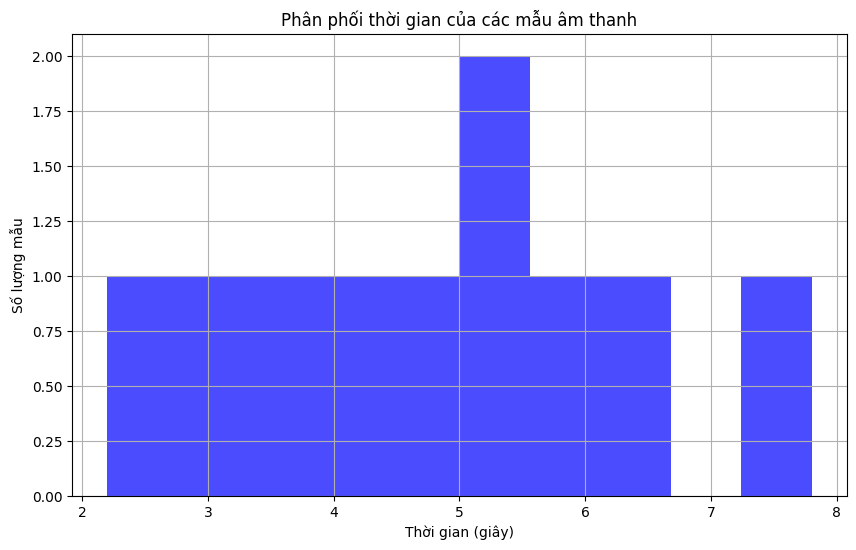

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Giả sử durations là một danh sách các độ dài mẫu âm thanh tính bằng giây
durations = [5.1, 4.2, 6.5, 3.3, 7.8, 2.2, 5.5, 3.5, 4.8, 6.1]  # ví dụ

# Tạo biểu đồ phân phối
plt.figure(figsize=(10, 6))
plt.hist(durations, bins=10, color='blue', alpha=0.7)
plt.title('Phân phối thời gian của các mẫu âm thanh')
plt.xlabel('Thời gian (giây)')
plt.ylabel('Số lượng mẫu')
plt.grid(True)
plt.show()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 1441 entries, 168 to 1126
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  1441 non-null   object 
 1   label     1441 non-null   object 
 2   offset    1441 non-null   float64
dtypes: float64(1), object(2)
memory usage: 45.0+ KB


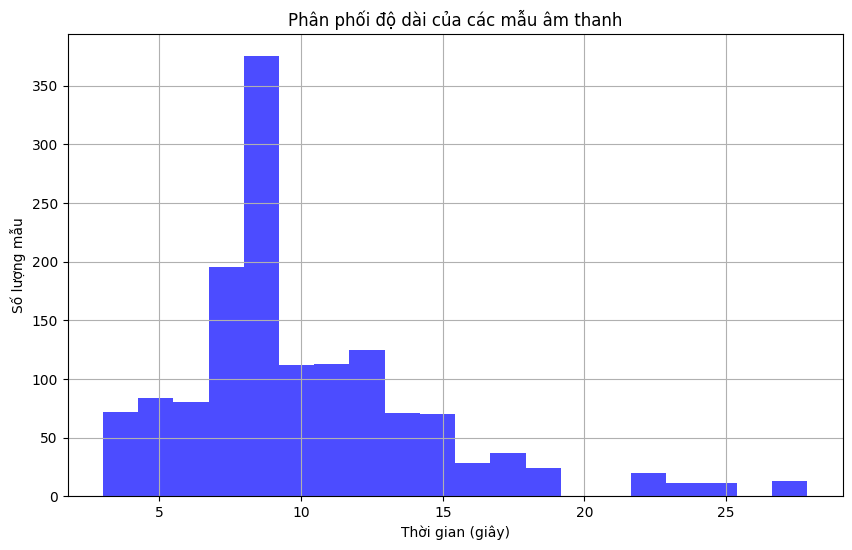

In [10]:
import os
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, matthews_corrcoef
import seaborn as sns

# Audio
import librosa
import librosa.display

# Scikit learn
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedShuffleSplit

# Keras
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# TensorFlow
from tensorflow.keras.utils import to_categorical

# Ignore warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

dataset = []
for folder in ["Heartbeat_Sounds/set_a/**","Heartbeat_Sounds/set_b/**"]:
    for filename in glob.iglob(folder):
        if os.path.exists(filename):
            label = os.path.basename(filename).split("_")[0]
            duration = librosa.get_duration(filename=filename)
            # skip audio smaller than 3 secs
            if duration>=3:
                slice_size = 3
                iterations = int((duration-slice_size)/(slice_size-1))
                iterations += 1
#                 initial_offset = (duration % slice_size)/2
                initial_offset = (duration - ((iterations*(slice_size-1))+1))/2
                if label not in ["Aunlabelledtest", "Bunlabelledtest"]:
                    for i in range(iterations):
                        offset = initial_offset + i*(slice_size-1)
                        
                        dataset.append({
                                "filename": filename,
                                "label": label,
                                "offset": offset
                            })
                       
                        
dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state=42)
dataset.info()


# Tính toán độ dài của từng mẫu âm thanh và thêm vào DataFrame
durations = []
for filename in dataset['filename']:
    duration = librosa.get_duration(filename=filename)
    durations.append(duration)

dataset['duration'] = durations

# Vẽ biểu đồ phân phối độ dài mẫu âm thanh
plt.figure(figsize=(10, 6))
plt.hist(dataset['duration'], bins=20, color='blue', alpha=0.7)
plt.title('Phân phối độ dài của các mẫu âm thanh')
plt.xlabel('Thời gian (giây)')
plt.ylabel('Số lượng mẫu')
plt.grid(True)
plt.show()


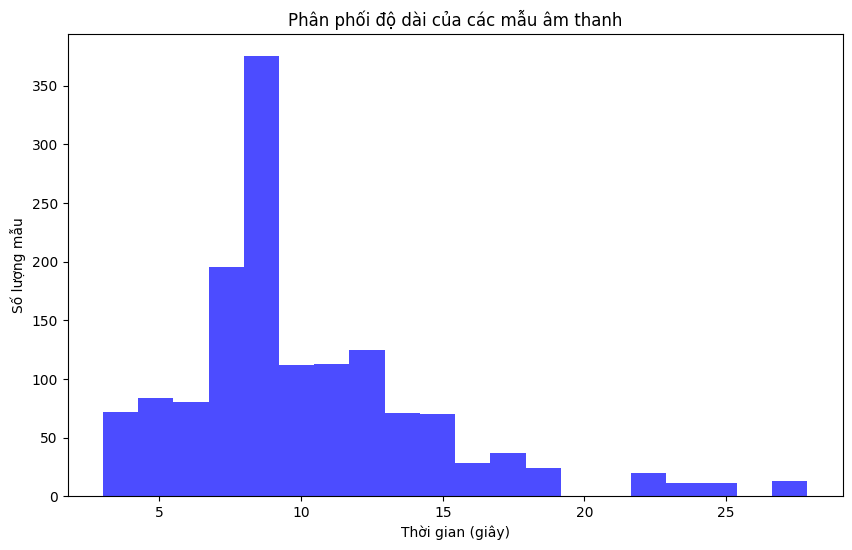

In [11]:
# Tính toán độ dài của từng mẫu âm thanh và thêm vào DataFrame
durations = []
for filename in dataset['filename']:
    duration = librosa.get_duration(filename=filename)
    durations.append(duration)

dataset['duration'] = durations

# Vẽ biểu đồ phân phối độ dài mẫu âm thanh
plt.figure(figsize=(10, 6))
plt.hist(dataset['duration'], bins=20, color='blue', alpha=0.7)
plt.title('Phân phối độ dài của các mẫu âm thanh')
plt.xlabel('Thời gian (giây)')
plt.ylabel('Số lượng mẫu')
plt.show()

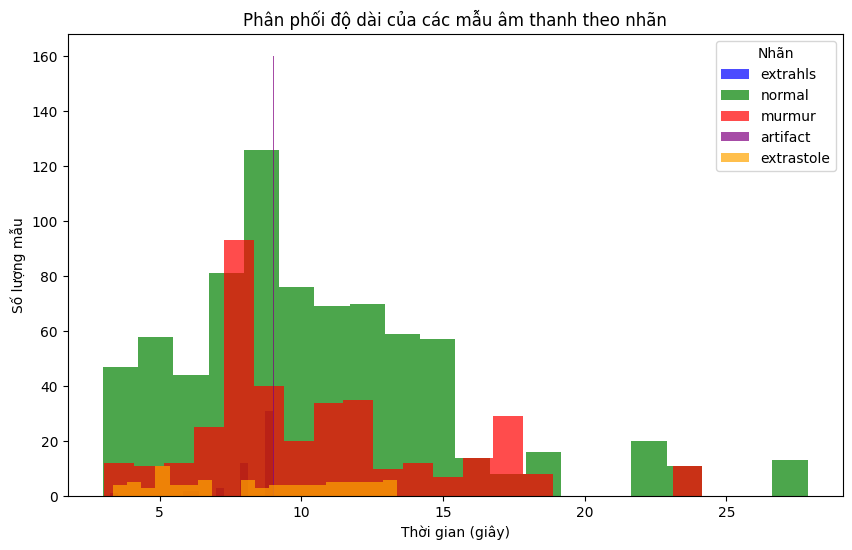

In [12]:
import librosa
import matplotlib.pyplot as plt
import pandas as pd

# Giả sử `dataset` là DataFrame chứa các cột 'filename' và 'label'
# Bạn cần thay thế tên cột 'label' bằng tên cột chứa nhãn phù hợp trong dữ liệu của bạn

# Tính toán độ dài cho từng mẫu âm thanh và thêm vào DataFrame
durations = []
labels = []

for index, row in dataset.iterrows():
    duration = librosa.get_duration(filename=row['filename'])
    durations.append(duration)
    labels.append(row['label'])

dataset['duration'] = durations
dataset['label'] = labels

# Tạo biểu đồ histogram cho mỗi nhãn
plt.figure(figsize=(10, 6))

labels_set = dataset['label'].unique()
colors = ['blue', 'green', 'red', 'purple', 'orange']  # Màu cho mỗi nhãn, thêm bớt tùy số lượng nhãn

for label, color in zip(labels_set, colors):
    subset = dataset[dataset['label'] == label]
    plt.hist(subset['duration'], bins=20, color=color, alpha=0.7, label=label)

plt.title('Phân phối độ dài của các mẫu âm thanh theo nhãn')
plt.xlabel('Thời gian (giây)')
plt.ylabel('Số lượng mẫu')
plt.legend(title='Nhãn')
plt.show()
